In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from scipy.stats import zscore
import pandas as pd
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm

from sklearn import svm
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from collections import Counter

from datetime import datetime
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)

# print(os.getcwd())

In [3]:
## Read raw data
df = pd.read_csv("data/full_dataframe_1node_2hrs_23dims.csv").drop('timestamp', 1)

## Remove redundant prefix name
prefix = "192.168.13.108.443-"
df.columns = [c.replace(prefix, "") for c in df.columns]

## Min-Max normalization
for c in df.columns:
    df[c] = MinMaxScaler().fit_transform(df[c].values.reshape((df[c].shape[0], -1)))

### Center points
## Read center of clusters
centers_df = pd.read_csv("data/data_cluster.csv")
feature_cols = list(set(centers_df.columns).intersection(set(df.columns)))

## get feature cols only
centers_df = centers_df[feature_cols]

## MinMax norm
for c in feature_cols:
    centers_df[c] = MinMaxScaler().fit_transform(centers_df[c].values.reshape((centers_df[c].shape[0], -1)))

## num of clusters   
len_cluster = centers_df.shape[0]

## convert pandas to list
center_list = [centers_df.iloc[i].values for i in range(len_cluster)]



## get feature cols only
df = df[feature_cols]

my_labels = pd.read_csv("data/pred.csv")

df_full = pd.concat([df, my_labels],1)

df_full.head()

Fan3RPMReading-RPMReading  ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower  Fan4RPMReading-RPMReading  DIMMSocketA1TemperatureReading-TemperatureReading  PowerMetricsTotalStoragePower-TotalMemoryPower  DIMMSocketA6TemperatureReading-TemperatureReading  CUPSSystemUsage-IOUsage  Fan2RPMReading-RPMReading  Fan1RPMReading-RPMReading  DIMMSocketA4TemperatureReading-TemperatureReading  CUPSSystemUsage-SystemUsage  DIMMSocketA3TemperatureReading-TemperatureReading  CUPSSystemUsage-MemoryUsage  CPU1TempTemperatureReading-TemperatureReading  Fan5RPMReading-RPMReading  PowerMetricsTotalStoragePower-SystemPowerConsumption  DIMMSocketA5TemperatureReading-TemperatureReading  PowerMetricsTotalStoragePower-TotalCPUPower  DIMMSocketA2TemperatureReading-TemperatureReading  ThermalTotalPSUHeatDissipation-PowerToCoolRatio  Fan6RPMReading-RPMReading  CPU2TempTemperatureReading-TemperatureReading  CUPSSystemUsage-CPUUsage  cluster
0                        0.0                                                        1.0                        0.0                                                1.0                                             0.6                                                0.0                      0.0                        0.0                        0.0                                                0.0                          0.0                                                1.0                          0.0                                            0.0                        0.0                                              0.034091                                                0.0                                     0.231156                                                0.0                                              1.0                        0.0                                            0.0                       0.0        0
1                        0.0                                                        1.0                        0.0                                                1.0                                             0.6                                                0.0                      0.0                        0.0                        0.0                                                0.0                          0.0                                                1.0                          0.0                                            0.0                        0.0                                              0.034091                                                0.0                                     0.231156                                                0.0                                              1.0                        0.0                                            0.0                       0.0        0
2                        0.0                                                        1.0                        0.0                                                1.0                                             0.6                                                0.0                      0.0                        0.0                        0.0                                                0.0                          0.0                                                1.0                          0.0                                            0.0                        0.0                                              0.034091                                                0.0                                     0.231156                                                0.0                                              1.0                        0.0                                            0.0                       0.0        0
3                        0.0                                                        1.0                        0.0                                                1.0                                             0.6                                          

In [7]:
df_full["cluster"].value_counts()

0    1698
6    1278
5     441
8     409
4     383
1     340
3     208
7     195
2      76
Name: cluster, dtype: int64

In [4]:
feature_cols

['Fan3RPMReading-RPMReading',
 'ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower',
 'Fan4RPMReading-RPMReading',
 'DIMMSocketA1TemperatureReading-TemperatureReading',
 'PowerMetricsTotalStoragePower-TotalMemoryPower',
 'DIMMSocketA6TemperatureReading-TemperatureReading',
 'CUPSSystemUsage-IOUsage',
 'Fan2RPMReading-RPMReading',
 'Fan1RPMReading-RPMReading',
 'DIMMSocketA4TemperatureReading-TemperatureReading',
 'CUPSSystemUsage-SystemUsage',
 'DIMMSocketA3TemperatureReading-TemperatureReading',
 'CUPSSystemUsage-MemoryUsage',
 'CPU1TempTemperatureReading-TemperatureReading',
 'Fan5RPMReading-RPMReading',
 'PowerMetricsTotalStoragePower-SystemPowerConsumption',
 'DIMMSocketA5TemperatureReading-TemperatureReading',
 'PowerMetricsTotalStoragePower-TotalCPUPower',
 'DIMMSocketA2TemperatureReading-TemperatureReading',
 'ThermalTotalPSUHeatDissipation-PowerToCoolRatio',
 'Fan6RPMReading-RPMReading',
 'CPU2TempTemperatureReading-TemperatureReading',
 'CUPSSystemUsage-CPUUsage']

In [3]:
df_full.iloc[0]

DIMMSocketA5TemperatureReading-TemperatureReading            0.000000
Fan1RPMReading-RPMReading                                    0.000000
CPU2TempTemperatureReading-TemperatureReading                0.000000
CUPSSystemUsage-IOUsage                                      0.000000
Fan3RPMReading-RPMReading                                    0.000000
DIMMSocketA1TemperatureReading-TemperatureReading            1.000000
PowerMetricsTotalStoragePower-SystemPowerConsumption         0.034091
ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower    1.000000
PowerMetricsTotalStoragePower-TotalCPUPower                  0.231156
DIMMSocketA3TemperatureReading-TemperatureReading            1.000000
Fan6RPMReading-RPMReading                                    0.000000
CPU1TempTemperatureReading-TemperatureReading                0.000000
PowerMetricsTotalStoragePower-TotalMemoryPower               0.600000
CUPSSystemUsage-SystemUsage                                  0.000000
Fan2RPMReading-RPMRe

## TRAIN

num feature_cols = 23 
Training until validation scores don't improve for 200 rounds
[100]	train's multi_logloss: 0.878368	valid's multi_logloss: 0.87706
[200]	train's multi_logloss: 0.504975	valid's multi_logloss: 0.503784
[300]	train's multi_logloss: 0.301542	valid's multi_logloss: 0.300568
[400]	train's multi_logloss: 0.182929	valid's multi_logloss: 0.18213
[500]	train's multi_logloss: 0.112317	valid's multi_logloss: 0.111703
[600]	train's multi_logloss: 0.0691472	valid's multi_logloss: 0.0686962
[700]	train's multi_logloss: 0.0426948	valid's multi_logloss: 0.0423697
[800]	train's multi_logloss: 0.0264619	valid's multi_logloss: 0.0262284
[900]	train's multi_logloss: 0.0163965	valid's multi_logloss: 0.0162389
[1000]	train's multi_logloss: 0.0101764	valid's multi_logloss: 0.0100697
[1100]	train's multi_logloss: 0.00634675	valid's multi_logloss: 0.00627502
[1200]	train's multi_logloss: 0.00396672	valid's multi_logloss: 0.00391924
[1300]	train's multi_logloss: 0.00248282	valid's multi_l

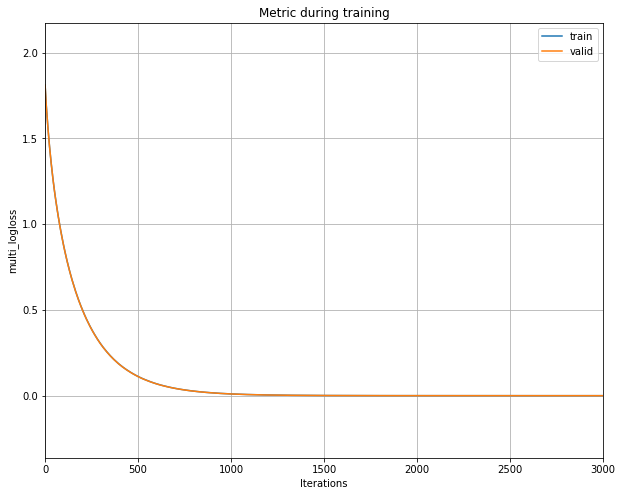

In [4]:
n_jobs = 16
feature_cols = feature_cols
cate_cols = list()
early_stopping = 200

using_SMOTE = False

feature_cols = feature_cols
cate_cols = list()

X_train, X_valid, y_train, y_valid = train_test_split(df_full[feature_cols], df_full["cluster"], test_size=0.33, random_state=2020, stratify = df_full["cluster"])


####################
## RUN THE MODEL ##
###################

## NO need to edit this cell ##

start_time = datetime.now()

random_seed = 2020

print("num feature_cols = {} ".format(len(feature_cols)))

## prepare the model
lgb_params = {
    'boosting_type':'gbdt', 'colsample_bytree':0.5, #'class_weight': {0 : 1. , 1: weight},
    'importance_type':'gain', 'learning_rate':0.005, 'max_depth':3,
    'min_child_samples':20,# 'min_child_weight':0.001, 'min_split_gain':0.0,
    'n_estimators':3000, 'n_jobs': n_jobs, 'num_leaves':31, 'subsample_freq':16,
    'seed': random_seed, 'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':True,
    'subsample':0.5, 'subsample_for_bin':200000,  "metric": "multi_logloss" ,'objective':"multiclass"
}

lgb_model = lgb.LGBMClassifier(**lgb_params)


record_store = dict()
lgb_model.fit( X=X_train, y=y_train, feature_name = feature_cols, #categorical_feature = cate_cols, 
              early_stopping_rounds= early_stopping, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              eval_names=["train", "valid"],
              eval_metric= "multi_logloss",
              verbose = 100, callbacks = [lgb.record_evaluation(record_store)])

# calc loss error for valid set
y_pred = lgb_model.predict(X_valid)
y_pred_prob = lgb_model.predict_proba(X_valid)


oof = pd.concat([X_valid, y_valid], 1)
oof['pred'] = y_pred
oof['prob_0'] = y_pred_prob[:,0]
oof['prob_1'] = y_pred_prob[:,1]

# plot learning curve 
f = lgb.plot_metric(record_store, figsize=(10,8))
training_time = datetime.now() - start_time

print("done in ", training_time)

# Check the model on trainning set

In [5]:
pred_train = lgb_model.predict(X_train)
print("Accuracy on trainning set", accuracy_score(y_train, pred_train))

Accuracy on trainning set 1.0


# Check the model on trainning set

In [6]:
pred_valid = lgb_model.predict(X_valid)
print("Accuracy on valid set", accuracy_score(y_valid, pred_valid))

Accuracy on valid set 1.0


In [7]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_valid)

shap_values_np = np.array(shap_values)
shap.initjs()

# Show feature importance for each feature of each class 

In [8]:
shap_importance = pd.DataFrame({"feature_name": feature_cols})

for i in range(len_cluster):
    shap_class_i = pd.DataFrame({"feature_name": feature_cols, f"cluster_{i}": np.abs(shap_values[i]).sum(axis=0)})
    shap_importance = pd.merge(shap_importance, shap_class_i, on="feature_name", how="inner")
shap_importance

feature_name    cluster_0    cluster_1   cluster_2    cluster_3    cluster_4    cluster_5    cluster_6   cluster_7    cluster_8
0           DIMMSocketA5TemperatureReading-TemperatureReading     0.000000     0.000000    0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000
1                                   Fan1RPMReading-RPMReading     0.000000     0.000000    0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000
2               CPU2TempTemperatureReading-TemperatureReading   490.131926    10.274332  101.523186   106.703500   194.587749   205.575993    79.676099  933.419240   182.263397
3                                     CUPSSystemUsage-IOUsage     0.000000     0.000000    0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000
4                                   Fan3RPMReading-RPMReading     0.000000     0.000000    0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000
5           DIMMSocketA1TemperatureReading-TemperatureReading  1383.564601  1666.558945  494.876342     4.117991     3.770264     0.173393     0.488225   67.256404     0.066864
6        PowerMetricsTotalStoragePower-SystemPowerConsumption   592.225059   773.173920  719.316225    42.324651     0.920312    33.234095   165.765461  931.224925  2008.136831
7   ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower  5480.516210   129.406876   36.169163    72.359295    52.380500    72.788187  2752.221071   93.044617  2238.032998
8                 PowerMetricsTotalStoragePower-TotalCPUPower   894.032443   229.055408  263.956549     6.727380     9.467128    10.895075  2422.328253  555.394289  1023.858875
9           DIMMSocketA3TemperatureReading-TemperatureReading   700.695717   893.098855  282.474801     5.595916     1.350568     0.081417     0.894098   16.413555     0.032628
10                                  Fan6RPMReading-RPMReading     0.387951     6.640735   96.945343   704.343334   711.860252  1970.489561   504.503412    9.881867     0.613870
11              CPU1TempTemperatureReading-TemperatureReading   251.141441     0.170603   19.782048    52.875795    93.546455    80.224312   156.132955  128.915910    71.520165
12             PowerMetricsTotalStoragePower-TotalMemoryPower   151.416487   291.297350  146.845710     3.764145     0.114069     0.142672     5.236782   85.468387   566.960172
13                                CUPSSystemUsage-SystemUsage     9.979363     0.047250    0.047069   796.464987  1549.479325   275.001376  1430.988590  648.772727   246.292413
14                                  Fan2RPMReading-RPMReading    19.020988     0.854401  393.267574  1278.093631   169.216044    45.172051     3.979100  121.720789   150.844681
15                                  Fan4RPMReading-RPMReading   356.091033    49.259962   20.418357   458.147600   388.917266   546.036870   560.754906   38.318528    33.144346
16          DIMMSocketA2TemperatureReading-TemperatureReading    17.906979     0.010477    0.506255     0.714617   944.025980   767.196425     1.867828   12.406052    91.540959
17          DIMMSocketA6TemperatureReading-TemperatureReading     0.000000     0.000000    0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000
18          DIMMSocketA4TemperatureReading-TemperatureReading     1.602801     0.072593    1.685098    31.118788  1081.356728   315.641532     0.003078    4.291059    29.666469
19                                CUPSSystemUsage-MemoryUsage     4.250458     0.130989    0.151356   405.473664   432.547827    14.475775  1695.705482  281.966504    10.096870
20                                  Fan5RPMReading-RPMReading     3.066584     0.198984  168.900612   200.082670   161.054220   981.748563   226.270615   64.970869    35.532380
21            ThermalTotalPSUHeatDissipation-PowerToCoolRatio  2908.742082   141.115206   64.286839    25.979809    52.854329    62.795427   862.741870   5

In [9]:
import plotly.graph_objects as go

x = list(range(len_cluster))

fig = go.Figure()
for i in range(shap_importance.shape[0]):
    fig.add_trace(go.Bar(x=x, y=shap_importance.iloc[i, 1:], name=shap_importance.iloc[i, 0]))


fig.update_layout(barmode='relative', title_text='Feature importance for each cluster, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

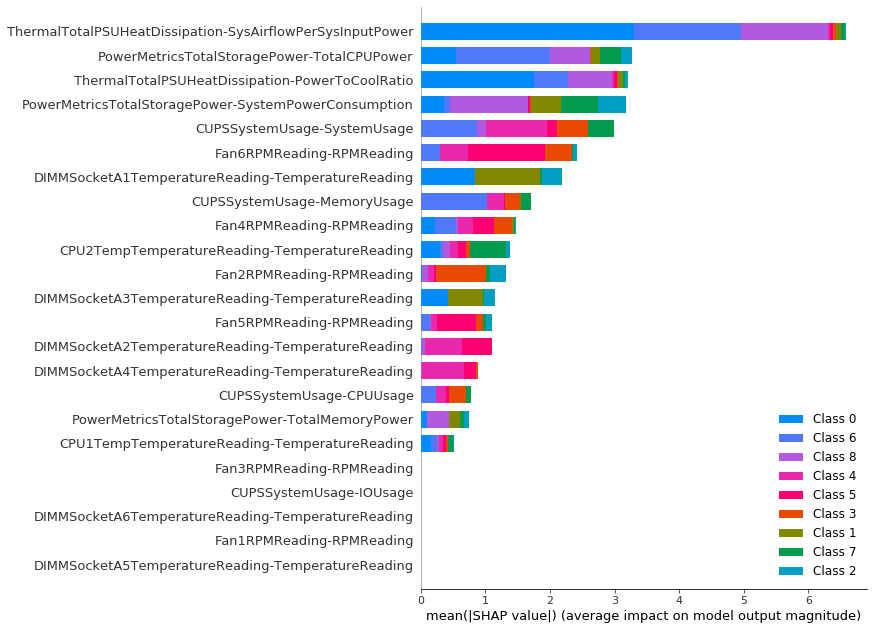

In [10]:
## Feature importance of each feature, colored by cluster

shap.summary_plot(shap_values, X_valid, max_display =  len(feature_cols), show=False, plot_type = "bar")

cluster 0


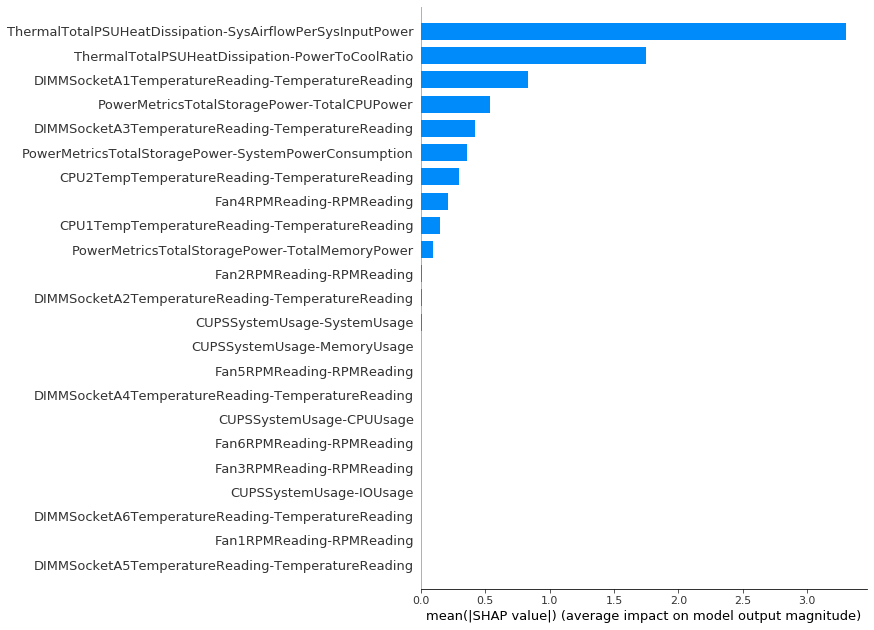



cluster 1


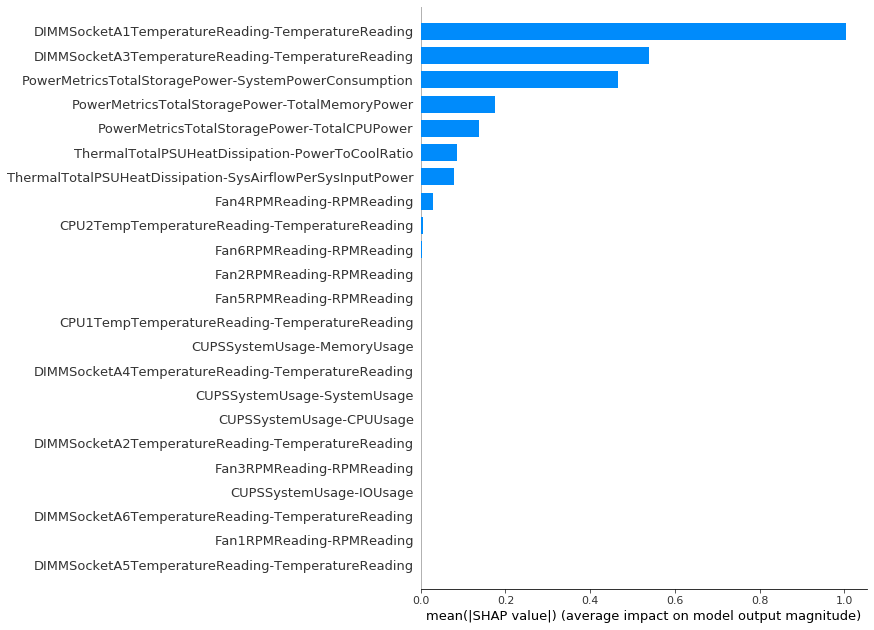



cluster 2


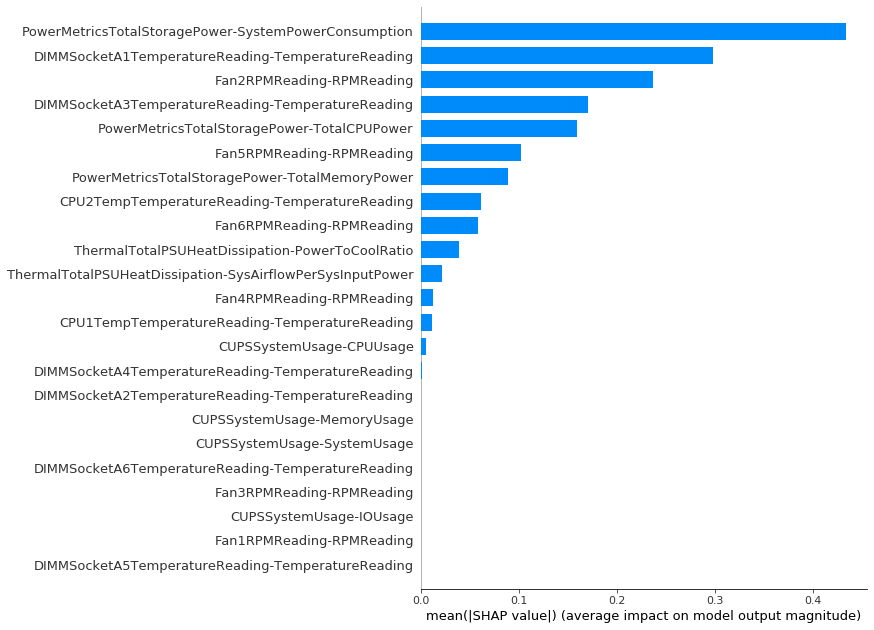



cluster 3


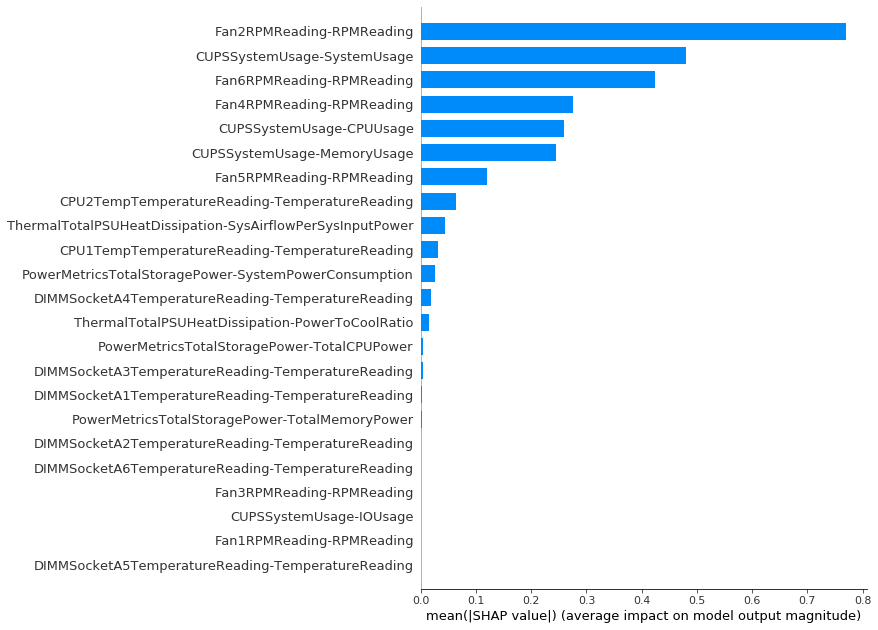



cluster 4


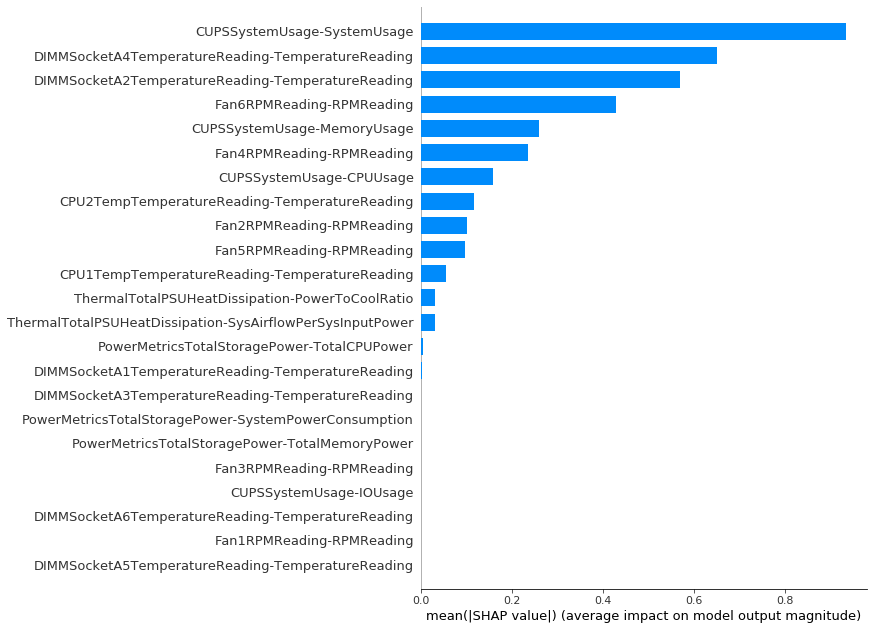



cluster 5


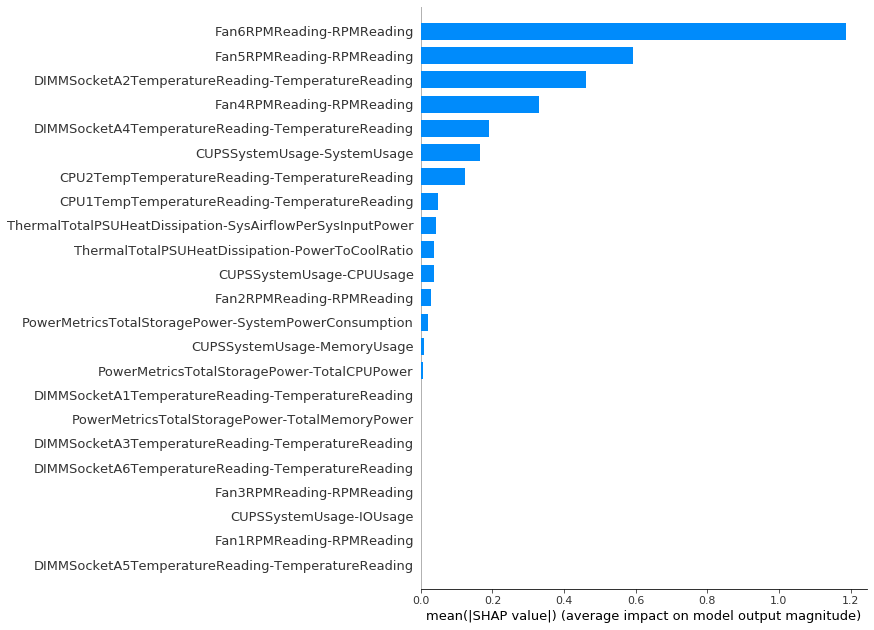



cluster 6


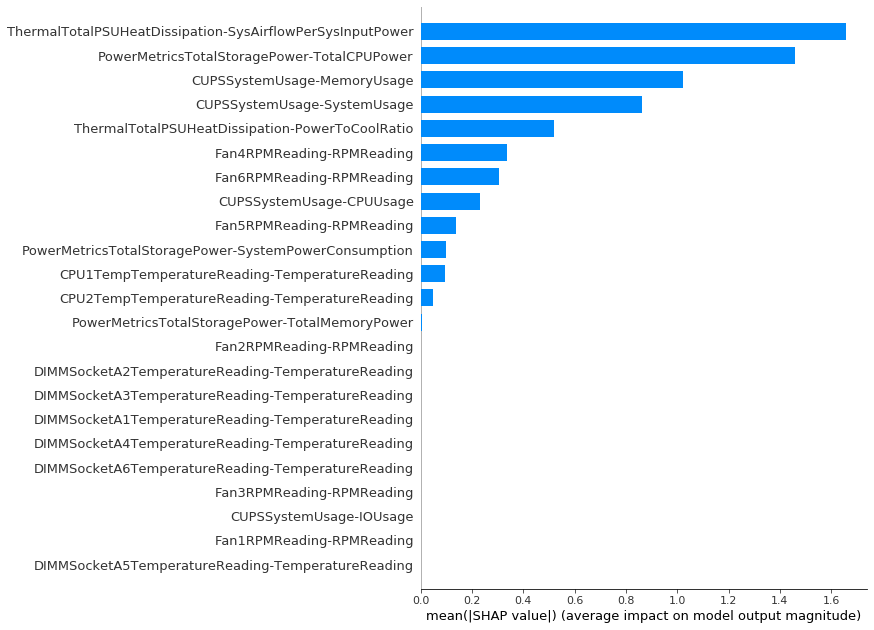



cluster 7


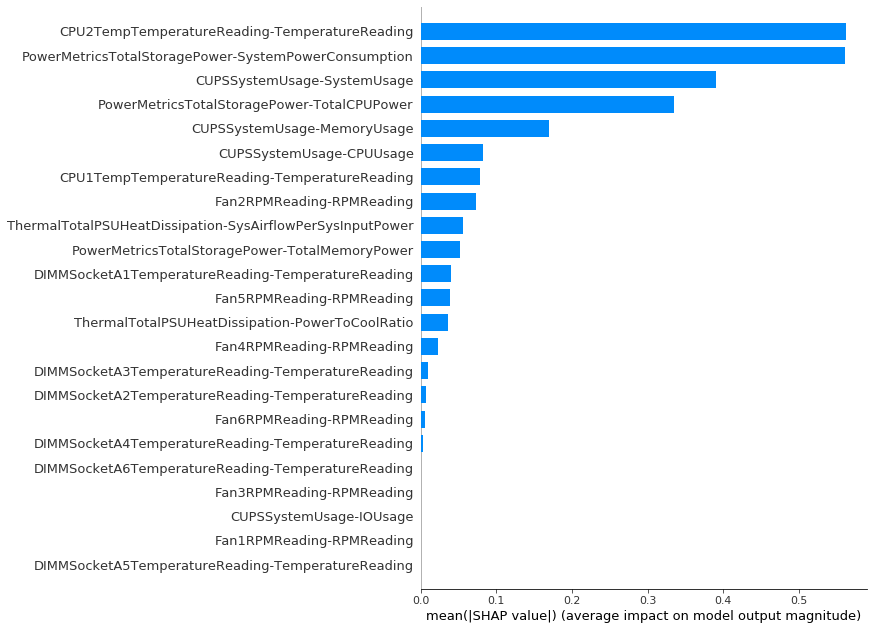



cluster 8


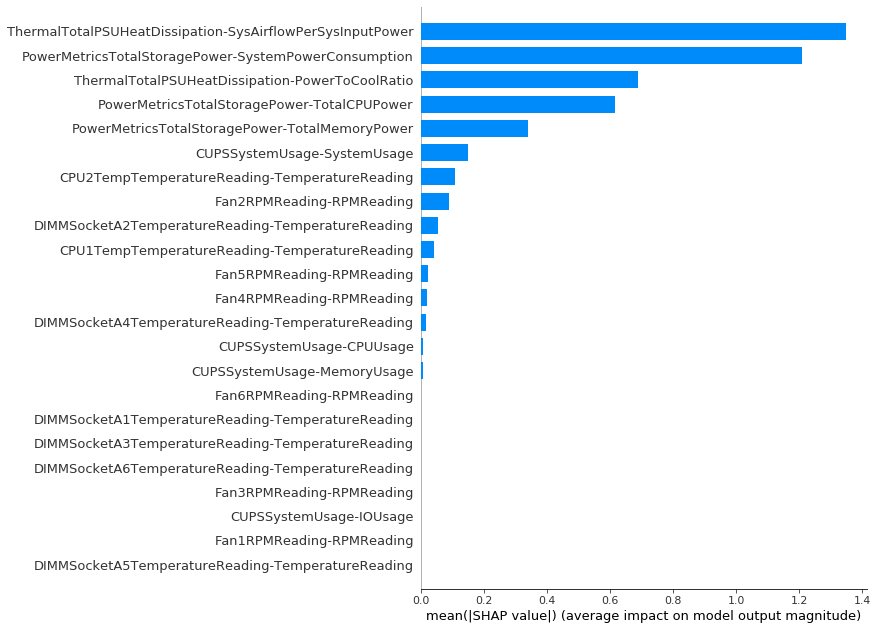

In [11]:
## Show top feature importances of each class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_valid, max_display =  len(feature_cols), show=False, plot_type = "bar")
    print("cluster", i)
    plt.show(f)
    print("\n")

# Show feature importance for each instance/observation

In [12]:
i = 0

x = list(range(len(feature_cols)))
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]
print("pred: Cluster", pred_valid[i])
for i in range(shape_1obs.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[:,i], name=feature_cols[i], mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

pred: Cluster 6


In [13]:
i = 0

x = feature_cols
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]
print("pred: Cluster", pred_valid[i])
for i in range(len_cluster):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[i,:], name=feature_cols[i], mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

pred: Cluster 6


Each feature has different contributions on each class.

Ex: Power to cool Ratio has a huge impact on class 0 (blue), whereas much smaller for class 7 (green)

cluster 0


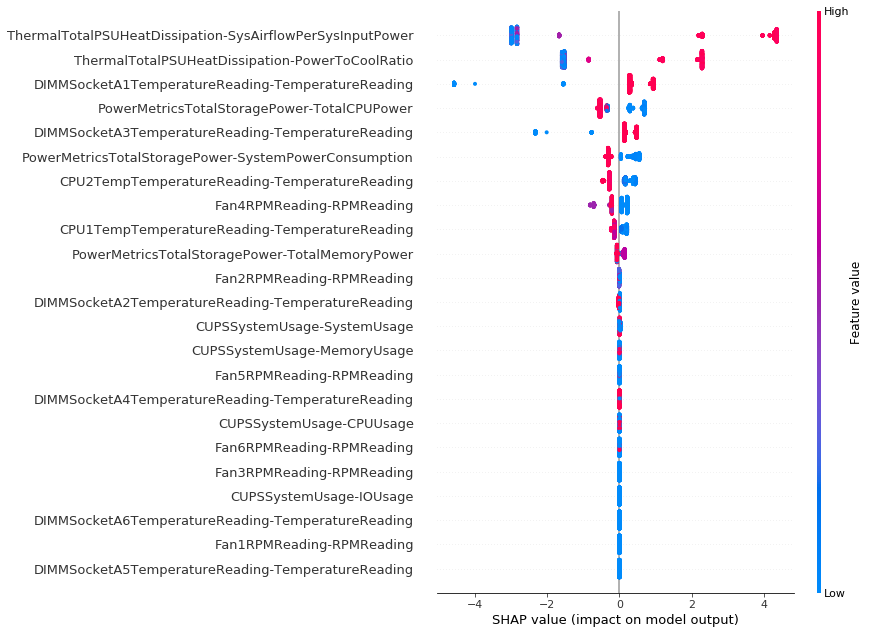



cluster 1


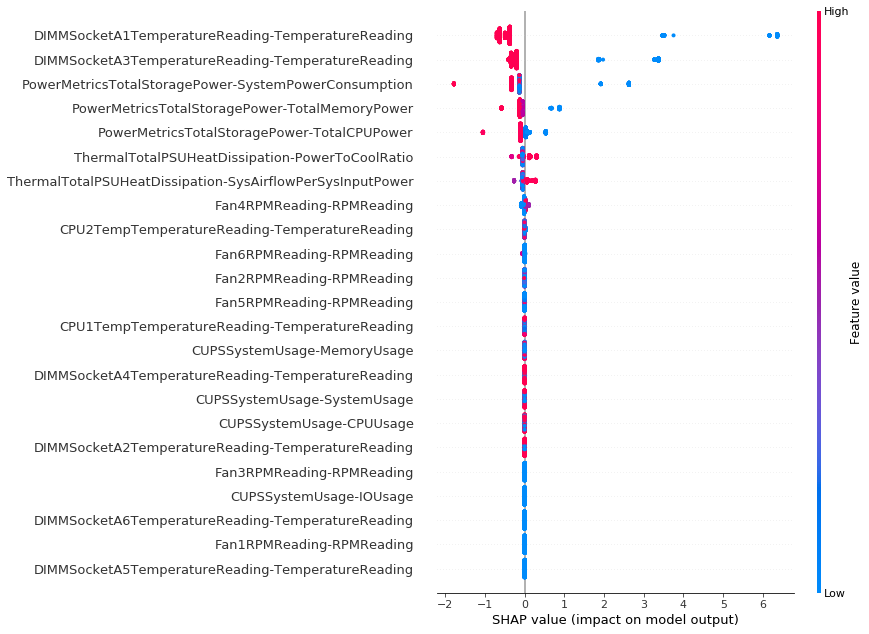



cluster 2


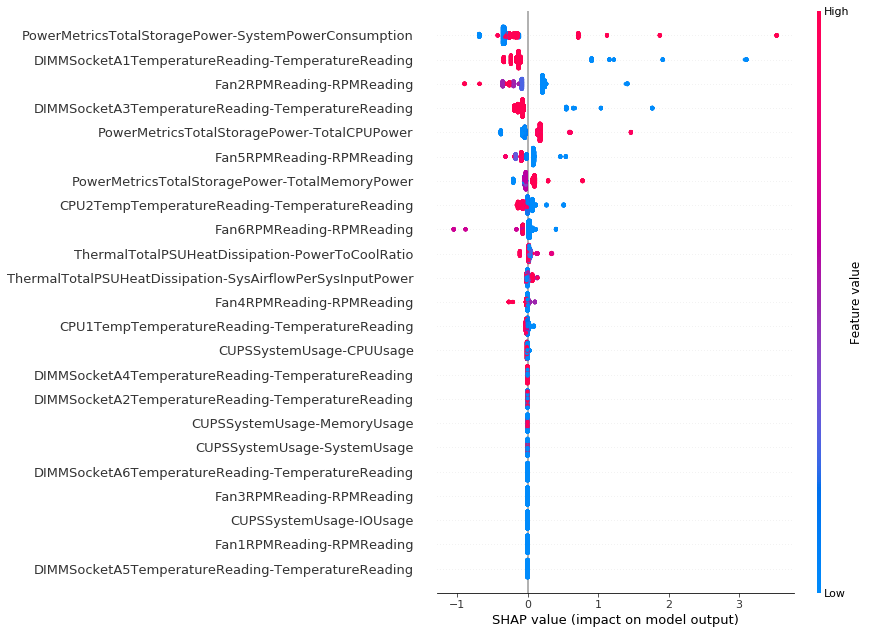



cluster 3


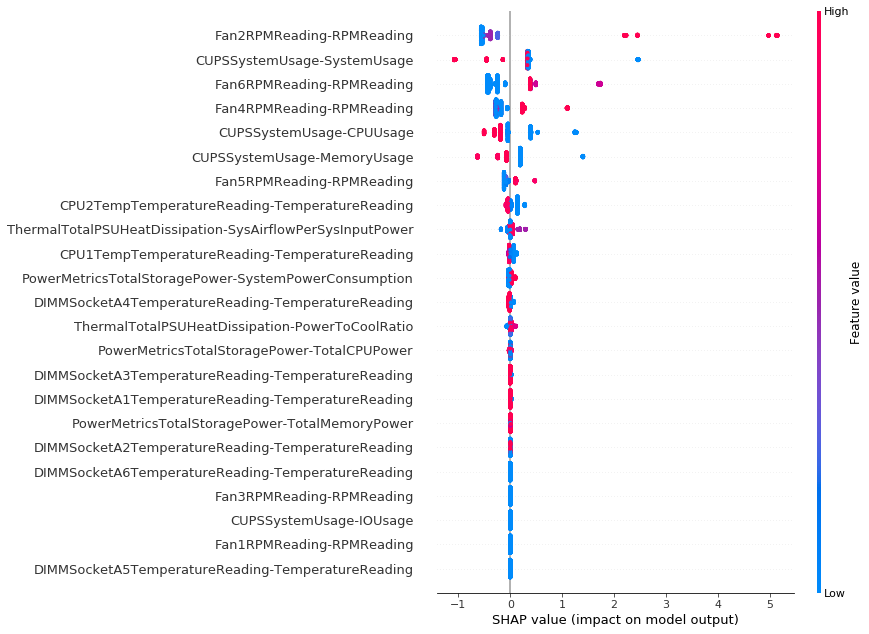



cluster 4


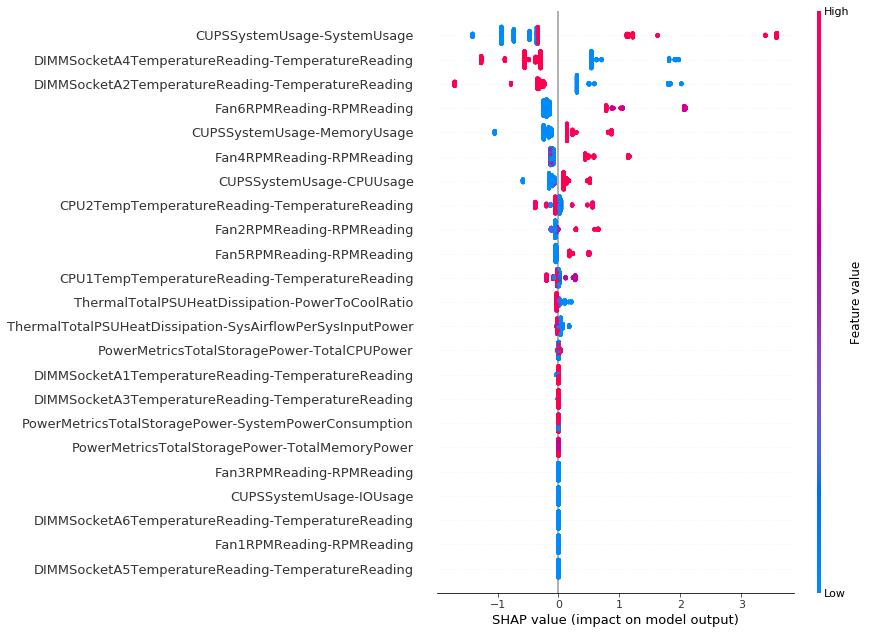



cluster 5


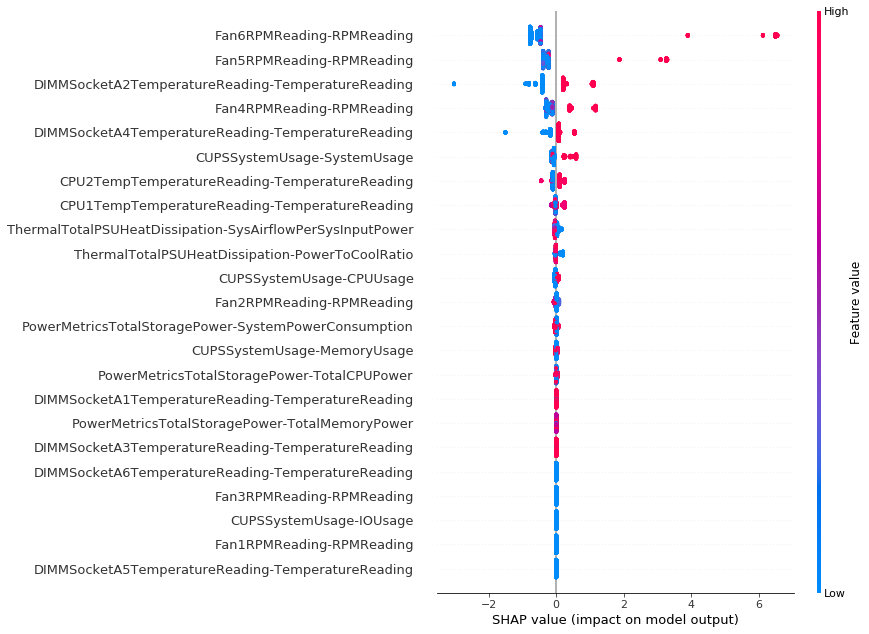



cluster 6


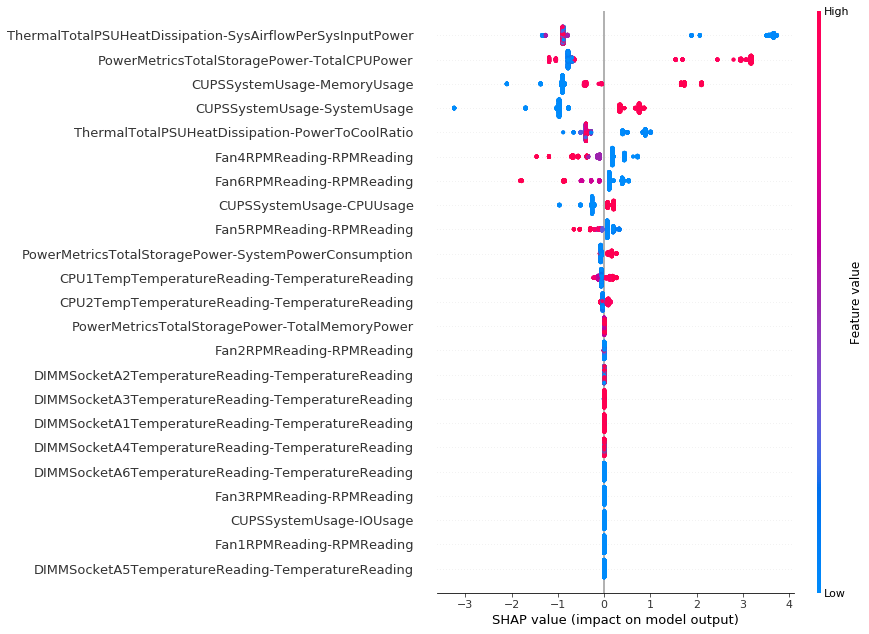



cluster 7


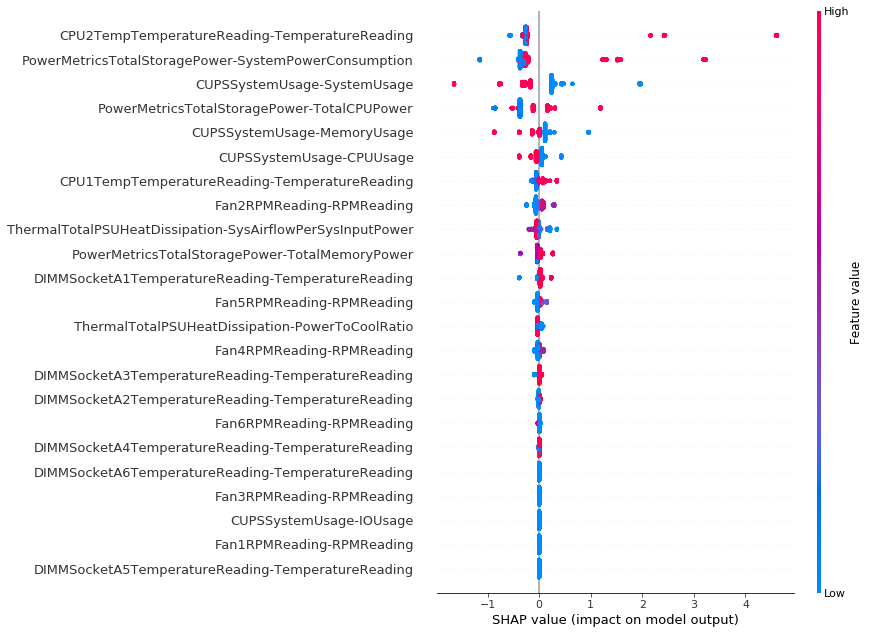



cluster 8


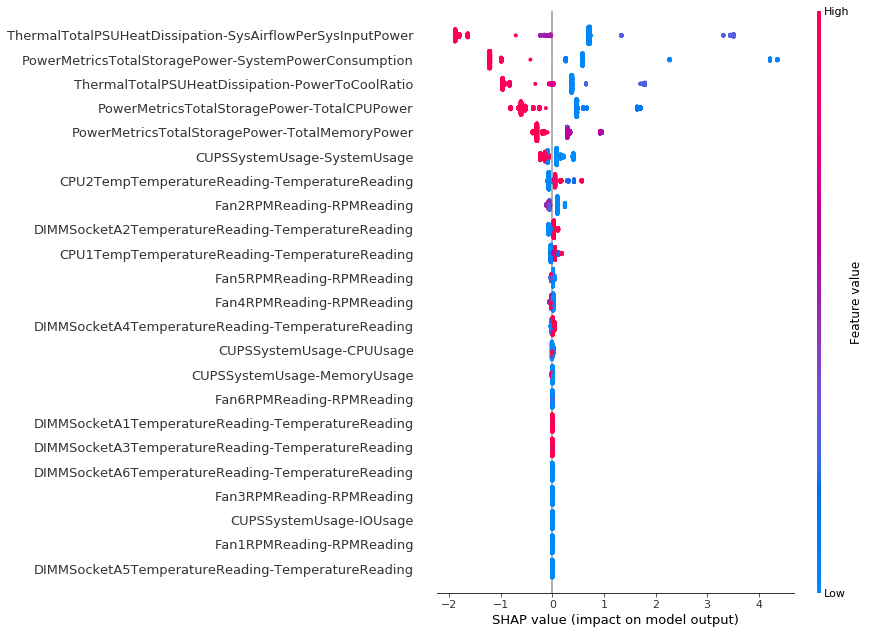

In [14]:
## Show feature importance for each instance/observation by class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_valid, max_display = len(feature_cols), show=False, plot_type = "dot")
    print("cluster", i)
    plt.show(f)
    print("\n")